# Impact of Prompt Caching on Inference Speed

In [67]:
import os
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import math
import re

In [83]:
benchmark_results_dir = "../../data/results/benchmark_results/"
csv_filename = "questions_traits_evaluation.csv"

comparisons = defaultdict(list)

for dirpath, _, filenames in os.walk(benchmark_results_dir):
    if csv_filename in filenames:
        model = os.path.basename(dirpath)
        filepath = os.path.join(dirpath, csv_filename)
        name = model.split("_")[-1]
        comparisons[name].append(pd.read_csv(filepath, index_col=0, usecols=["question_id", "prompt_id", "model_id", "accuracy"] ))
comparison_dict = dict(comparisons)

In [84]:
def retrieve_time(model_name):
    log_name = "log.out"
    log_dirpath = os.path.join(benchmark_results_dir, model_name)
    log_filepath = os.path.join(log_dirpath, log_name)
    with open(log_filepath, "r", encoding="utf-8") as f:
        contents = f.read()
        time_str = re.search(r"Total execution time:\s(\d+)\sseconds", contents)
        time = int(time_str.group(1)) / 60
        return time

In [87]:
def merge_data(model_name, summary_filename="summary.csv"):
    dataframes = comparison_dict[model_name]
    df1 = dataframes[0]
    df2 = dataframes[1]
    df1.index.name = 'question_id'
    df2.index.name = 'question_id'
    
    dataframes = pd.merge(
        df1[['accuracy', 'model_id']], 
        df2[['accuracy', 'model_id']],
        on='question_id',
        suffixes=('_PCL', '_L')
        )
    
    # loading the summaries
    pcl_dir = os.path.join(benchmark_results_dir, f"PCL_{model_name}")
    l_dir = os.path.join(benchmark_results_dir, f"L_{model_name}")
    

    try:
        summary_pcl = pd.read_csv(os.path.join(pcl_dir, summary_filename))
        summary_l = pd.read_csv(os.path.join(l_dir, summary_filename))

        success_ratio_pcl = summary_pcl["success_ratio"].astype(float).mean()
        success_ratio_l = summary_l["success_ratio"].astype(float).mean()

    except FileNotFoundError:
        print(f"⚠️ Warning: Missing summary.csv for model {model_name}")
        success_ratio_pcl = 0.0
        success_ratio_l = 0.0

    # Flip accuracy -> error spotting
    dataframes["error_rate_PCL"] = 1 - dataframes["accuracy_PCL"]
    dataframes["error_rate_L"] = 1 - dataframes["accuracy_L"]

    time_pcl = retrieve_time(f"PCL_{model_name}")
    time_l   = retrieve_time(f"L_{model_name}")

    dataframes["inference_time_PCL"] = time_pcl
    dataframes["inference_time_L"] = time_l

    dataframes["ESS_PCL"] = (dataframes["error_rate_PCL"] * success_ratio_pcl) / time_pcl
    dataframes["ESS_L"] = (dataframes["error_rate_L"] * success_ratio_l) / time_l

    
    
    return dataframes


In [88]:
all_merged = {}
for key, values in comparison_dict.items():
    merged = merge_data(key)
    all_merged[key] = merged

In [81]:
def plot_comparisons(name, merged_data, row=0, col=0, axes=None):
    if axes is None:
        fig, ax = plt.subplots(4, 2, figsize=(10, 8))

    ax = axes[row, col]
    ax = merged_data[["ESS_PCL","ESS_L"]].plot(kind="bar", ax=ax, rot=0, legend=False)
    ax.set_title(name)
    ax.set_ylabel("ESS")
    ax.set_ylim(0, 0.5)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    return axes

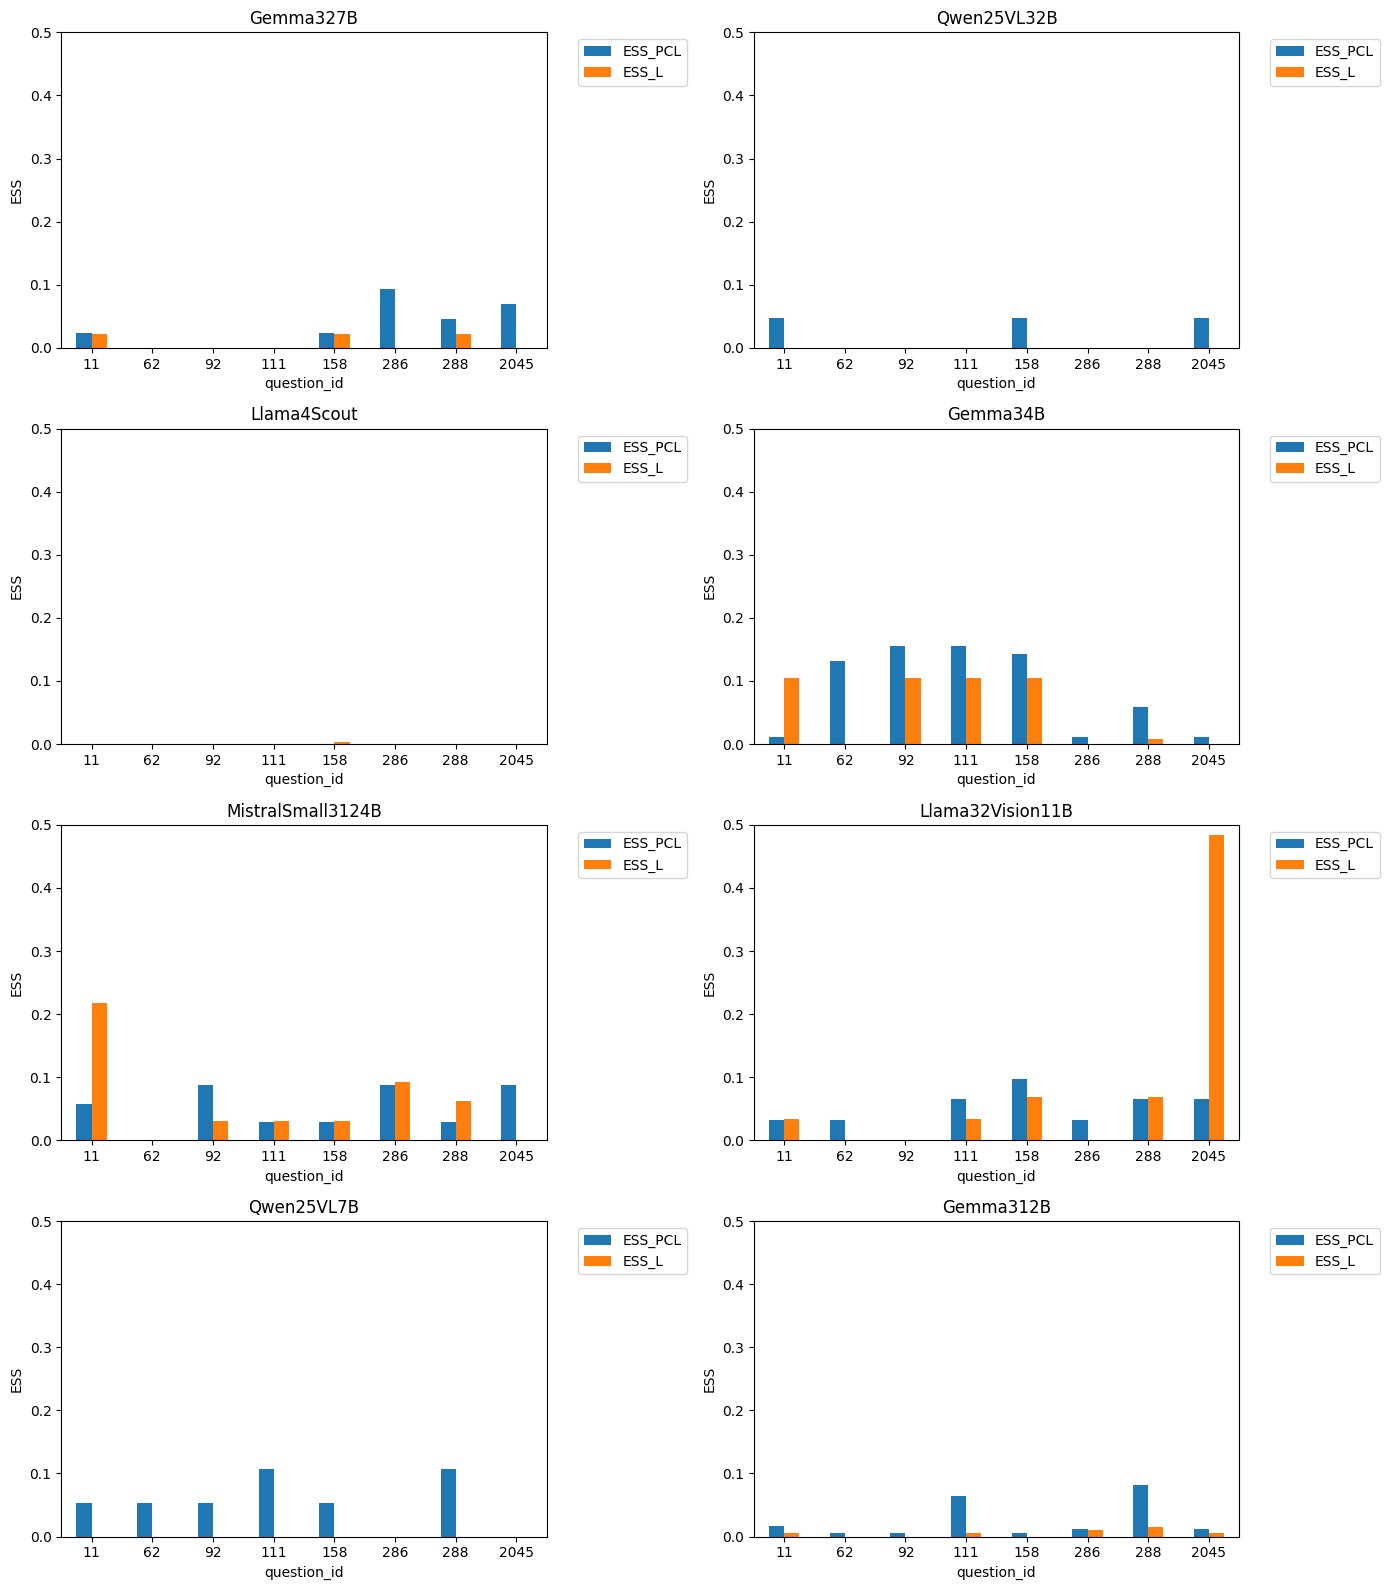

In [89]:
n_models = len(all_merged)
n_cols = 2
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.reshape(n_rows, n_cols)

for i, (model, data) in enumerate(all_merged.items()):
    row, col = divmod(i, n_cols)
    plot_comparisons(model, data, row=row, col=col, axes=axes)

plt.tight_layout()
plt.show()

In [94]:
def rank_models_by_ess(all_merged, top_n=5):
    ranking = []

    for model, df in all_merged.items():
        ess_pcl = df["ESS_PCL"].mean()
        ess_l   = df["ESS_L"].mean()

        ranking.append((f"PCL_{model}", ess_pcl))
        ranking.append((f"L_{model}", ess_l))

    # Sort by ESS descending
    top_models = sorted(ranking, key=lambda x: x[1], reverse=True)[:top_n]

    # Print leaderboard
    print("🏆 Top Models by ESS (spotting skill per minute):\n")
    for rank, (name, score) in enumerate(top_models, 1):
        print(f"#{rank} → {name}: {score:.4f}")

    return top_models


In [95]:
top_models = rank_models_by_ess(all_merged, top_n=10)


🏆 Top Models by ESS (spotting skill per minute):

#1 → L_Llama32Vision11B: 0.0864
#2 → PCL_Gemma34B: 0.0848
#3 → L_MistralSmall3124B: 0.0582
#4 → L_Gemma34B: 0.0536
#5 → PCL_Qwen25VL7B: 0.0536
#6 → PCL_MistralSmall3124B: 0.0510
#7 → PCL_Llama32Vision11B: 0.0488
#8 → PCL_Gemma327B: 0.0319
#9 → PCL_Gemma312B: 0.0254
#10 → PCL_Qwen25VL32B: 0.0177


In [100]:
def plot_model_ranking(ranking):
    labels = [name for name, _ in ranking]
    scores = [score for _, score in ranking]

    plt.figure(figsize=(10, 5))
    plt.barh(labels[::-1], scores[::-1], color="skyblue")
    plt.xlabel("ESS (error spotting score per minute)")
    plt.title("Model Ranking by ESS Efficiency")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show();


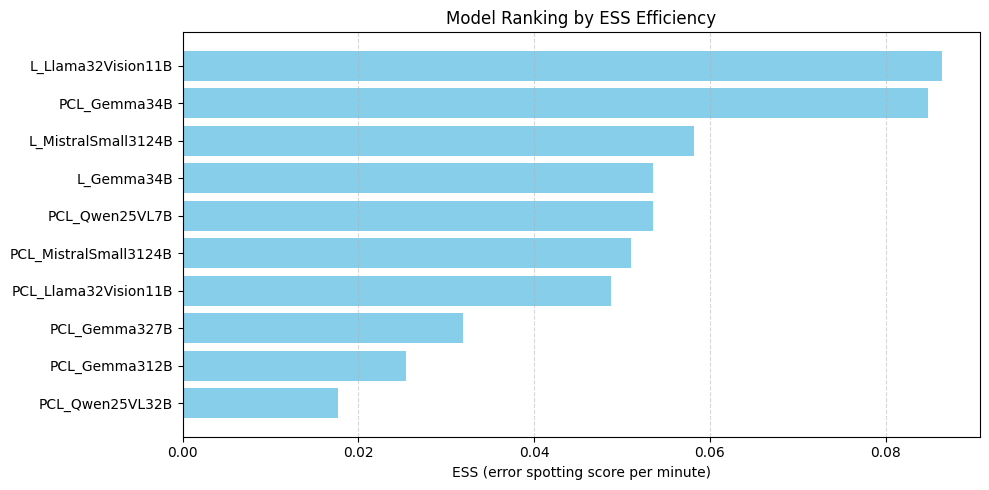

In [101]:
plot_model_ranking(top_models)
